# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Инструкция по выполнению проекта
- Загрузите и подготовьте данные. Поясните порядок действий.
- Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
- Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
- Проведите финальное тестирование.

# Описание данных
- Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
    - Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
    - Целевой признак
- Exited — факт ухода клиента

# 1. Подготовка данных

In [385]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings("ignore")

In [386]:
#Прочитаем данные и выведем всю необходимую информацию.
df = pd.read_csv('/datasets/Churn.csv')

print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Имеем пропуски в "Tenure". Можем устранить с помощью медианы количества недвижимости у клиента для каждого возраста. 

In [387]:
for item in df['Age'].unique():
    filter_flags = df['Tenure'].isna() & (df['Age'] == item)
    df.loc[filter_flags, 'Tenure'] = df.loc[df['Age'] == item, 'Tenure'].median()

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [389]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Удалим столбцы - 'RowNumber', 'CustomerId', 'Surname' из обучающей выборки.

In [390]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

Преобразуем категориальные признаки в числовые с помощью техники прямого кодирования(One-Hot Encoding, OHE). Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies()
чтобы избежать дамми-ловушки, используем аргумент drop_first=True

In [391]:
df_ohe = pd.get_dummies(df, drop_first = True)
df_ohe.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8.0,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7.0,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4.0,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4.0,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2.0,134603.88,1,1,1,71725.73,0,0,0,1


Разобьем данные на выборки:
    - тестовая
    - валидационная 
    - обучающую
Используя функцию train_test_split из библиетеки sklearn.model_selection
Разделим сначала df на df_train и df_valid_test, а потом df_valid_test на df_valid и df_test

In [392]:
y = df['Exited']
df_train, df_valid_test = train_test_split(df_ohe, test_size = 0.4, random_state = 12345, stratify = y)
df_valid, df_test = train_test_split(df_valid_test, test_size = 0.5, random_state = 12345)

Выведем размеры полученных выборок.

In [393]:
print(df_test.shape)
print(df_valid.shape)
print(df_train.shape)

(2000, 12)
(2000, 12)
(6000, 12)


In [394]:
#Разделим каждую выборку на features и target.
features_test = df_test.drop(['Exited'], axis = 1)
target_test = df_test['Exited']

features_valid = df_valid.drop(['Exited'], axis = 1)
target_valid = df_valid['Exited']

features_train = df_train.drop(['Exited'], axis = 1)
target_train = df_train['Exited']

Для того, чтобы отмаштабировать признаки, воспотльзуемся одним из методов масштабирования — стандартизации данных.
В sklearn есть отдельная структура для стандартизации данных — StandardScaler
Преобразуем обучающую,валидационную и тестовую выборки функцией transform().

In [395]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Выводы по главе 1:
- Преобразовали данные для пригодного для обучения модели состояния.
- Использовали технику прямого кодирования, стандартизации данных и разбивку на выборки:
    - Обучающая - для обучения моделей,
    - Валидационная - для настройки гиперпараметров модели,
    - Тестовая - для окончательной проверки модели на неизвестных данных и оценки качества модели

# 2. Исследование задачи

Данная задача относиться к задачам классификации, в нашем случае бинарной классификации.
Рассмотрим 3 модели:
* Решающее дерево DecisionTreeClassifier из библиотеки sklearn.tree
* Случайный лес RandomForestClassifier из библиотеки sklearn.ensemble 
* Логистическая регрессия LogisticRegression из библиотеки sklearn.linear_model

Сразу введем псевдослучайность для алгоритма обучения, используя генератор псевдослучайных чисел random_state. Таким образом модель будет воспринимать данные как случайные, для нас это необходимо , чтобы результаты неизменно получались одинаковыми (другими словами, повторить удачный эксперимент).

### Решающее дерево - DecisionTreeClassifier
Создадим модель и запишем в переменную tree_model, обучим модель используя метод fit() на признаках features_train и целевом признаке target_train.

In [396]:
tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

Чтобы предсказать ответы, вызовем метод predict()и передать ему таблицу с признаками новых объектов features_valid.
Посчитаем оценку точности предсказания accuracy_score для модели, сравнив предсказания tree_valid_predictions и правильные ответы target_valid в валидационной выборке.

In [397]:
tree_predicted_valid = tree_model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, tree_predicted_valid)
accuracy_valid

0.7845

### Случайный лес - RandomForestClassifier

Создадим модель случайный лес и запишем в переменную forest_model, обучим модель используя метод fit() на признаках features_train и целевом признаке target_train.

In [398]:
forest_model = RandomForestClassifier(random_state = 12345)
forest_model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Чтобы предсказать ответы, вызовем метод predict()и передать ему таблицу с признаками новых объектов features_valid.
Посчитаем оценку точности предсказания accuracy_score для модели, сравнив предсказания forest_predicted_valid и правильные ответы target_valid в валидационной выборке.

In [399]:
forest_predicted_valid = forest_model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, forest_predicted_valid)
accuracy_valid

0.851

### Логистическая регрессия - LogisticRegression

Создадим модель Логистическая регрессия и запишем в переменную logistic_model, обучим модель используя метод fit() на признаках features_train и целевом признаке target_train.

In [400]:
logistic_model = LogisticRegression(random_state = 12345)
logistic_model.fit(features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Чтобы предсказать ответы, вызовем метод predict()и передать ему таблицу с признаками новых объектов features_valid.
Посчитаем оценку точности предсказания accuracy_score для модели, сравнив предсказания logistic_predicted_valid и правильные ответы target_valid в валидационной выборке.

In [401]:
logistic_predicted_valid = logistic_model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, logistic_predicted_valid)
accuracy_valid

0.815

### Проверка адекватности модели

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0». Количество уникальных значений подсчитаем методом value_counts().
Методом plot() c аргументом kind='bar' построим диаграмму.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


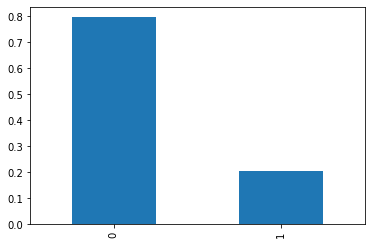

In [402]:
class_frequency = df['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar')

Создадим константную модель: любому объекту она прогнозирует класс «0».
Сохраним её предсказания в переменной target_pred_constant. Подсчитаем значение accuracy.

In [403]:
target_pred_constant = pd.Series(0 for i in range(len(target_valid)))
target_pred_constant.value_counts()

0    2000
dtype: int64

In [404]:
accuracy_score(target_valid, target_pred_constant)

0.8045

Построим матрицу ошибок для каждой модели из модуля sklearn.metrics. Функция confusion_matrix() :

In [405]:
logistic_confusion = confusion_matrix(target_valid, logistic_predicted_valid)
logistic_confusion

array([[1550,   59],
       [ 311,   80]])

In [406]:
tree_confusion = confusion_matrix(target_valid, tree_predicted_valid)
tree_confusion

array([[1386,  223],
       [ 208,  183]])

In [407]:
forest_confusion = confusion_matrix(target_valid, forest_predicted_valid)
forest_confusion

array([[1534,   75],
       [ 223,  168]])

Полнота recall выявляет, какую долю положительных среди всех ответов выделила модель. Функция recall_score из модуля sklearn.metrics. Посчитаем для каждой модели:

In [408]:
print('Полнота Логистической регресии:{:.2f}'.format(recall_score(target_valid, logistic_predicted_valid)))
print('Полнота Решающего Дерева:{:.2f}'.format(recall_score(target_valid, tree_predicted_valid)))
print('Полнота Случайного Леса:{:.2f}'.format(recall_score(target_valid, forest_predicted_valid)))

Полнота Логистической регресии:0.20
Полнота Решающего Дерева:0.47
Полнота Случайного Леса:0.43


Точность precision определяет, как много отрицательных ответов нашла модель, пока искала положительные. Чем больше отрицательных, тем ниже точность. Функция precision_score из модуля sklearn.metrics. Посчитаем для каждой модели:

In [409]:
print('Точность Логистической регресии:{:.2f}'.format(precision_score(target_valid, logistic_predicted_valid)))
print('Точность Решающего Дерева:{:.2f}'.format(precision_score(target_valid, tree_predicted_valid)))
print('Точность Случайного Леса:{:.2f}'.format(precision_score(target_valid, forest_predicted_valid)))

Точность Логистической регресии:0.58
Точность Решающего Дерева:0.45
Точность Случайного Леса:0.69


F1-мера - это среднее гармоническое полноты и точности. Функция f1_score из модуля sklearn.metrics. Посчитаем для каждой модели:

In [410]:
print('F1-мера Логистической регресии:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1-мера Решающего Дерева:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1-мера Случайного Леса:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))


F1-мера Логистической регресии:0.30
F1-мера Решающего Дерева:0.46
F1-мера Случайного Леса:0.53


## Выводы по главе 2:
На качество обученной модели проверили Решающее дерево, Случайный лес и Логистическую регрессию. Результаты оказались хорошими, однако при изучении классов выявили дисбаланс, 0-го класса в 4 раза больше 1-го. Проверку на адекватность обученные модели не прошли.
Используя новые метрики оценки модели: recall, precision и f1, оказалось что модели далеки от идельно предсказывающих. Особенно f1 мера показала адекватные оценки качества модели. Имеено эта метрика будет основной для оценки моделей

# 3. Борьба с дисбалансом

Взвешивание классов.
Придадим объектам редкого класса больший вес.
В алгоритмах решающего дерева, случайного леса и логистической регрессии в библиотеке sklearn есть аргумент class_weight.
Используем его, обучая модели.

In [411]:
logistic_model = LogisticRegression(random_state=12345, class_weight='balanced')
logistic_model.fit(features_train, target_train)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
tree_model.fit(features_train, target_train)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345, class_weight='balanced')
forest_model.fit(features_train, target_train)
forest_predicted_valid = forest_model.predict(features_valid)

In [412]:
print('F1-мера Логистической регресии:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1-мера Решающего Дерева:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1-мера Случайного Леса:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1-мера Логистической регресии:0.50
F1-мера Решающего Дерева:0.46
F1-мера Случайного Леса:0.53


### Увеличение выборки upsampling

* Разделим обучающую выборку на отрицательные и положительные объекты

In [413]:
#features_zeros = features_train[target_train == 0]
#features_ones = features_train[target_train == 1]
#target_zeros = target_train[target_train == 0]
#target_ones = target_train[target_train == 1]

#print(features_zeros.shape)
#print(features_ones.shape)
#print(target_zeros.shape)
#print(target_ones.shape)

* Скопируем несколько раз положительные объекты
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.

Напишем функцию upsample(features, target, repeat) для формирования сблалансированной выборки:

In [414]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 11)
(9666,)


In [415]:
#Обучим модели на расширенной выборке:
logistic_model = LogisticRegression(random_state=12345, class_weight='balanced')
logistic_model.fit(features_upsampled, target_upsampled)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
tree_model.fit(features_upsampled, target_upsampled)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345, class_weight='balanced')
forest_model.fit(features_upsampled, target_upsampled)
forest_predicted_valid = forest_model.predict(features_valid)

In [416]:
print('F1-мера Логистической регресии:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1-мера Решающего Дерева:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1-мера Случайного Леса:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1-мера Логистической регресии:0.50
F1-мера Решающего Дерева:0.48
F1-мера Случайного Леса:0.55


### Уменьшение выборки downsampling

* Разделим обучающую выборку на отрицательные и положительные объекты
* Случайным образом отбросим часть из отрицательных объектов;
* С учётом полученных данных создадим новую обучающую выборку;
* Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.
    
Напишем функцию downsample(features, target, repeat) для формирования сблалансированной выборки:

In [417]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [418]:
#Обучим модели на уменьшеной выборке:

logistic_model = LogisticRegression(random_state=12345)
logistic_model.fit(features_downsampled, target_downsampled)
logistic_predicted_valid = logistic_model.predict(features_valid)

tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_downsampled, target_downsampled)
tree_predicted_valid = tree_model.predict(features_valid)

forest_model = RandomForestClassifier(random_state=12345)
forest_model.fit(features_downsampled, target_downsampled)
forest_predicted_valid = forest_model.predict(features_valid)

In [419]:
print('F1-мера Логистической регресии:{:.2f}'.format(f1_score(target_valid, logistic_predicted_valid)))
print('F1-мера Решающего Дерева:{:.2f}'.format(f1_score(target_valid, tree_predicted_valid)))
print('F1-мера Случайного Леса:{:.2f}'.format(f1_score(target_valid, forest_predicted_valid)))

F1-мера Логистической регресии:0.49
F1-мера Решающего Дерева:0.46
F1-мера Случайного Леса:0.56


Доля истинно положительных ответов TPR - отношение TP-ответов ко всем положительным ответам(P).
Доля ложноположительных ответов FPR - отношение FP-ответов ко всем отрицательным ответам (N).

ROC-кривая, или кривая ошибок - зависимость доли ложноположительных ответов (FPR) и доли истинно положительных ответов (TPR), в зависимости от значения порога классификации
Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC

Напишем функцию auc_roc(model), которая столит roc-кривую и вычисляет AUC-ROC.

In [420]:
def auc_roc(model, name):
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC-кривая'.format(name))
    plt.show()
    
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('AUC-ROC равно:', auc_roc)
    return

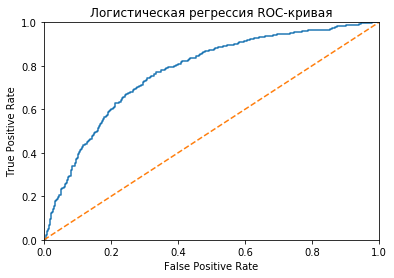

AUC-ROC равно: 0.7723053985017143


In [421]:
auc_roc(logistic_model, 'Логистическая регрессия')

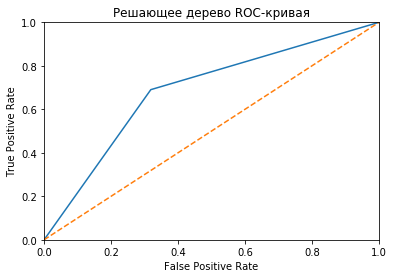

AUC-ROC равно: 0.6858527559968782


In [422]:
auc_roc(tree_model, 'Решающее дерево')

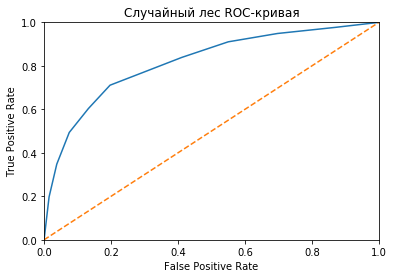

AUC-ROC равно: 0.8163598619657012


In [423]:
auc_roc(forest_model, 'Случайный лес')

### Подборка гиперпараметров

#### 1. Решающее дерево - DecisionTreeClassifier

In [424]:
tree_model = DecisionTreeClassifier(random_state=12345)
tree_model.fit(features_upsampled, target_upsampled)
tree_predicted_valid = tree_model.predict(features_valid)
f1_score(target_valid, tree_predicted_valid)

0.47969543147208116

In [425]:
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(start=5, stop=15, num=5)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
class_weight = ['balanced']

tree_grid = {'criterion': criterion,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'class_weight': class_weight
            }


print(tree_grid)

{'criterion': ['gini', 'entropy'], 'max_depth': [5, 7, 10, 12, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': ['balanced']}


In [426]:
tree_test_model = DecisionTreeClassifier(random_state=12345)

In [427]:
tree_random = RandomizedSearchCV(estimator=tree_test_model, scoring='f1',
                                 param_distributions=tree_grid, verbose=2, refit='f1',
                                 random_state=123, n_jobs=-1)

tree_random.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=2, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=5, min_samples_leaf=4, max_depth=10, criterion

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  min_samples_split=10, min_samples_leaf=1, max_depth=12, criterion=gini, class_weight=balanced, total=   0.0s
[CV] min_samples_split=10, min_samples_leaf=1, max_depth=12, criterion=gini, class_weight=balanced 
[CV]  min_samples_split=10, min_samples_leaf=1, max_depth=12, criterion=gini, class_weight=balanced, total=   0.0s
[CV] min_samples_split=10, min_samples_leaf=1, max_depth=12, criterion=gini, class_weight=balanced 
[CV]  min_samples_split=10, min_samples_leaf=1, max_depth=12, criterion=gini, class_weight=balanced, total=   0.0s
[CV] min_samples_split=10, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=10, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_split=10, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=balanced 
[CV]  min_samples_split=10, min_samples_leaf=4, max_depth=5, criterion=entropy, class_weight=balanced, total=   0.0s
[CV] min_samples_

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=12345,
                                                    splitter='

In [428]:
print("best cv f1-score: ", round(tree_random.best_score_, 2))

best cv f1-score:  0.55


In [429]:
print("best params:")
tree_random.best_params_

best params:


{'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

max_depth - максимальная глубина дерева. Переберем в цикле значения от 1 до 20:

In [430]:
%%time

tree_balance_model = DecisionTreeClassifier(random_state=321, **tree_random.best_params_
                                           ).fit(features_train, target_train)
tree_balance_predictions = tree_balance_model.predict(features_test)
tree_balance_probas = tree_balance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, tree_balance_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, tree_balance_predictions), auc_roc))

F1 = 0.63, AUC = 0.87
CPU times: user 45.1 ms, sys: 24 µs, total: 45.1 ms
Wall time: 44.1 ms


In [431]:
%%time
for depth in range(1,21):
    tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree_model.fit(features_upsampled, target_upsampled)
    tree_predicted_valid = tree_model.predict(features_valid)
    print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, tree_predicted_valid))

Глубина дерева: 1 F1-мера: 0.4838160136286202
Глубина дерева: 2 F1-мера: 0.5
Глубина дерева: 3 F1-мера: 0.5
Глубина дерева: 4 F1-мера: 0.5406871609403254
Глубина дерева: 5 F1-мера: 0.5186385737439222
Глубина дерева: 6 F1-мера: 0.5343228200371057
Глубина дерева: 7 F1-мера: 0.5424354243542435
Глубина дерева: 8 F1-мера: 0.5359116022099447
Глубина дерева: 9 F1-мера: 0.5200803212851406
Глубина дерева: 10 F1-мера: 0.5143442622950819
Глубина дерева: 11 F1-мера: 0.5188374596340151
Глубина дерева: 12 F1-мера: 0.5069222577209799
Глубина дерева: 13 F1-мера: 0.4994400895856664
Глубина дерева: 14 F1-мера: 0.49191685912240185
Глубина дерева: 15 F1-мера: 0.47904191616766467
Глубина дерева: 16 F1-мера: 0.4779411764705882
Глубина дерева: 17 F1-мера: 0.4778325123152709
Глубина дерева: 18 F1-мера: 0.4846938775510204
Глубина дерева: 19 F1-мера: 0.4910941475826972
Глубина дерева: 20 F1-мера: 0.4816223067173637
CPU times: user 848 ms, sys: 241 µs, total: 849 ms
Wall time: 889 ms


Изменим критерий Джини на энтропию:

#### 2. Случайный лес - RandomForestClassifier

In [432]:
forest_model = RandomForestClassifier(random_state=12345)
forest_model.fit(features_downsampled, target_downsampled)
forest_predicted_valid = forest_model.predict(features_valid)
f1_score(target_valid, forest_predicted_valid)

0.563894523326572

n_estimators - количество деревьев. Переберем в цикле значения от 5 до 100 с шагом 5:n_estimators - количество деревьев. Переберем в цикле значения от 5 до 100 с шагом 5:

In [433]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=3)]
max_depth = [int(x) for x in np.linspace(start=3, stop=12, num=5)]
criterion = ['gini', 'entropy']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

forest_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight
              }


print(forest_grid)

{'n_estimators': [100, 150, 200], 'max_depth': [3, 5, 7, 9, 12], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced', 'balanced_subsample', None]}


In [434]:
forest_test_model = RandomForestClassifier(random_state=12345)

In [435]:
forest_random = RandomizedSearchCV(estimator=forest_test_model, scoring='f1',
                                   param_distributions=forest_grid, verbose=2,
                                   refit='f1', random_state=12345, n_jobs=-1)

forest_random.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True, total=   1.4s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True, total=   1.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_depth=7, criterion=entropy, class_weight=balanced_subsample, bootstrap=True, total=   1.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, criterion=entropy, class_weight=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, criterion=entropy, class_weight=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, criterion=entropy, class_weight=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_depth=3, criterion=entropy, class_weight=None, boot

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.1s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs

In [436]:
print("best cv f1-score: ", round(forest_random.best_score_, 2))

best cv f1-score:  0.61


In [437]:
print("best params:")
forest_random.best_params_

best params:


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True}

In [438]:
%%time

forest_balance_model = RandomForestClassifier(random_state=325, **forest_random.best_params_
                                             ).fit(features_train, target_train)
forest_balance_predictions = forest_balance_model.predict(features_test)
forest_balance_probas = forest_balance_model.predict_proba(features_test)
auc_roc = roc_auc_score(target_test, forest_balance_probas[:, 1])

print("F1 = {:.2f}, AUC = {:.2f}".format(
    f1_score(target_test, forest_balance_predictions), auc_roc))

F1 = 0.64, AUC = 0.87
CPU times: user 865 ms, sys: 3.98 ms, total: 869 ms
Wall time: 889 ms


In [439]:
%%time
for estimators in range(5,101,5):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=estimators)
    forest_model.fit(features_upsampled, target_upsampled)
    forest_predicted_valid = forest_model.predict(features_valid)
    print(estimators,':', f1_score(target_valid, forest_predicted_valid))

5 : 0.5641677255400254
10 : 0.5690140845070423
15 : 0.5672043010752689
20 : 0.5673758865248227
25 : 0.5674931129476585
30 : 0.5746799431009957
35 : 0.581267217630854
40 : 0.579020979020979
45 : 0.5809128630705395
50 : 0.5879043600562588
55 : 0.5805555555555556
60 : 0.5779036827195467
65 : 0.5813630041724618
70 : 0.5839210155148097
75 : 0.5809128630705395
80 : 0.5862552594670406
85 : 0.5829846582984658
90 : 0.5842696629213484
95 : 0.5829846582984658
100 : 0.5786516853932585
CPU times: user 15.6 s, sys: 139 ms, total: 15.7 s
Wall time: 16.4 s


max_depth - максимальная глубина дерева. Переберем в цикле значения от 1 до 20:

In [440]:
for depth in range(1,21):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=depth)
    forest_model.fit(features_upsampled, target_upsampled)
    forest_predicted_valid = forest_model.predict(features_valid)
    print('Глубина дерева:', depth, 'F1-мера:', f1_score(target_valid, forest_predicted_valid))

Глубина дерева: 1 F1-мера: 0.5223367697594502
Глубина дерева: 2 F1-мера: 0.5522388059701493
Глубина дерева: 3 F1-мера: 0.5448028673835126
Глубина дерева: 4 F1-мера: 0.5736434108527132
Глубина дерева: 5 F1-мера: 0.5778210116731517
Глубина дерева: 6 F1-мера: 0.5852674066599395
Глубина дерева: 7 F1-мера: 0.5909090909090909
Глубина дерева: 8 F1-мера: 0.5921192758253462
Глубина дерева: 9 F1-мера: 0.5989071038251366
Глубина дерева: 10 F1-мера: 0.6017897091722595
Глубина дерева: 11 F1-мера: 0.6107226107226107
Глубина дерева: 12 F1-мера: 0.5878048780487803
Глубина дерева: 13 F1-мера: 0.5807259073842302
Глубина дерева: 14 F1-мера: 0.5865633074935399
Глубина дерева: 15 F1-мера: 0.5603112840466925
Глубина дерева: 16 F1-мера: 0.5737483085250339
Глубина дерева: 17 F1-мера: 0.5652759084791387
Глубина дерева: 18 F1-мера: 0.5636856368563685
Глубина дерева: 19 F1-мера: 0.5741496598639455
Глубина дерева: 20 F1-мера: 0.577777777777778


min_samples_split - гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки. Переберем в цикле значения от 2 до 10:

In [441]:
for sample in range(2,11):
    forest_model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=7, min_samples_split=sample)
    forest_model.fit(features_downsampled, target_downsampled)
    forest_predicted_valid = forest_model.predict(features_valid)
    print(sample,':', f1_score(target_valid, forest_predicted_valid))

2 : 0.5938104448742746
3 : 0.5865384615384616
4 : 0.5925925925925926
5 : 0.5825426944971537
6 : 0.5795996186844614
7 : 0.5750000000000001
8 : 0.5822050290135397
9 : 0.5834127740705434
10 : 0.5906432748538012


In [442]:
forest_model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=7)
forest_model.fit(features_upsampled, target_upsampled)
forest_predicted_valid = forest_model.predict(features_valid)
f1_score(target_valid, forest_predicted_valid)

0.5909090909090909

Качество модели наилучшее при n_estimators=35, max_depth=7

Так как модель определена и ее гиперпараметры выяснены, объеденим обучающую и валидационную выборку, используя метод .append, для того чтобы обучить модель еще немного лучше.

In [443]:
df_train_valid = df_train.append(df_valid, ignore_index = True)
df_train_valid.shape

(8000, 12)

In [444]:
features_train_valid = df_train_valid.drop(['Exited'], axis=1)
target_train_valid = df_train_valid['Exited']

In [445]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train_valid[numeric])
features_train_valid[numeric] = scaler.transform(features_train_valid[numeric])

In [446]:
features_train_valid_upsampled, target_train_valid_upsampled = upsample(features_train_valid, target_train_valid, 4)

print(features_train_valid_upsampled.shape)
print(target_train_valid_upsampled.shape)

(12839, 11)
(12839,)


Заново обучим модель Случайный лес model_random_forest с настроенными гиперпараметрами на расширенной выборке:

In [447]:
forest_model = RandomForestClassifier(random_state=12345, n_estimators=35, max_depth=7)
forest_model.fit(features_train_valid_upsampled, target_train_valid_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

# Выводы по главе 3:
- Проверили несколько способов борьбы с дисбалансом.
- Построили ROC кривые для каждой модели и посчитали AUC-ROC.
- Для выбранной модели Случайный лес, увеличение выборки upsampling оказалось самым оптимальным

# 4. Тестирование модели

In [448]:
rf_fin = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=210).fit(features_downsampled, target_downsampled)

In [449]:
print('Показатели модели на тестовой выборке:')
print('Accuracy {:}'.format(rf_fin.score(features_test, target_test)))
print('f1_score {:.3}'.format(f1_score(target_test, rf_fin.predict(features_test))))

Показатели модели на тестовой выборке:
Accuracy 0.795
f1_score 0.621


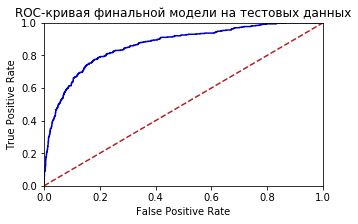

AUC-ROC финальной модели = 0.8643


In [450]:
p_test = rf_fin.predict_proba(features_test)
p_one_test = p_test[:, 1]

auc_roc = roc_auc_score(target_test, p_one_test)

fpr, tpr, thresholds = roc_curve(target_test, p_one_test)

plt.figure(figsize=(5,3))

plt.plot(fpr, tpr, color='mediumblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая финальной модели на тестовых данных')
    
plt.show()
print('AUC-ROC финальной модели = {:.4}'.format(auc_roc))

Вычислим значение f1 меры модели на тестовой выборке:

In [451]:
forest_predicted_valid = forest_model.predict(features_test)
print('F1-мера:', f1_score(target_test, forest_predicted_valid))

F1-мера: 0.6293018682399213


Построим roc-кривую и вычислим AUC-ROC для нашей модели.

In [452]:
print('AUC-ROC финальной модели = {:.4}'.format(auc_roc))

AUC-ROC финальной модели = 0.8643


# Выводы по главе 4:
- Обученная модель Случайный Лес на тестовой выборке показала F1-меру: 0.593
- Чтобы выявить, как сильно наша модель отличается от случайной, вычислили AUC-ROC равное: 0.853 
- По ROC кривой можно увидеть при каких порогам классификации модель дает оптимальные метики

# Глава 5. Общий вывод
- Модель Случайный лес показала самые лучшие результаты из 3 моделей.
- Проведя балансировку выборки и перебрав гиперпараметры модели, удалось достичь F1-меру: 0.593
- Чтобы выявить, как сильно наша модель отличается от случайной, вычислили AUC-ROC равное: 0.853. Модель предсказывает лучше случайной на 35%.
- Обученную для задачи классификации модель можно использовать для прогнозирования, уйдёт клиент из банка в ближайшее время или нет.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*